## 進階機器學習 HW3-1 
#### Develop several RNN models to classify the images MNIST dataset.
* 學號: B103040047
* 姓名: 周安

### Predict the digit number of the image.

In [12]:
TRAIN_DIR = "../HW2/HW2_MNIST_train/"
TEST_DIR = "../HW2/HW2_MNIST_test/"

In [13]:
%matplotlib inline

In [14]:
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

import os
# from torchsummary import summary
from torchinfo import summary # better for showing LSTM, RNN, CNN model info, which is an improvised version

import time

In [15]:
import random

import torch
import numpy as np

# for reproduce rsult
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(42)

### Function in transform
* **Move the digit into middle of the img. And, somtimes increase its size.**  
    Cut the img in original shape, and put the digit into 64*64 image size.  
    If the digit is too big, it don't cut this img, just resize into 64*64 instead.

In [16]:
import cv2

# Hyper Parameters
LR = 0.01
batch_size_train = 32
batch_size_val = 32
batch_size_test = 32
NUM_EPOCHS = 20

IMAGE_SIZE = 32  # Target image size after preprocessing

SEQ_LEN = 2 # for rnn

# Load MNIST image and preprocess it
def preprocess_mnist_cv2(image_tensor):
    """
    Preprocess MNIST images by locating the digit, centering it, and resizing.
    Args:
        image_tensor (torch.Tensor): Input tensor of shape (1, 128, 128).
    Returns:
        PIL.Image: Processed image with digit centered and resized.
    """
    # Convert tensor to NumPy array (ensure grayscale shape is preserved)
    img = image_tensor.numpy().squeeze(0)  # Shape: (128, 128)

    # Normalize pixel values to 0-255 (convert from range 0-1 if needed)
    img = (img * 255).astype(np.uint8)

    # Apply thresholding to segment the digit, turn digit into 255 and background into 0
    _, binary_img = cv2.threshold(img, 5, 255, cv2.THRESH_BINARY)

    # Find contours (detecting digit boundary)
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return Image.fromarray(img)  # If no contours found, return original image

    # Get bounding box of the detected digit
    x, y, w, h = cv2.boundingRect(contours[0])

    
    # prevent it detect wrong area like a dot
    if w*h < 50:
        return Image.fromarray(img)
    # Crop the digit
    digit_roi = img[y:y+h, x:x+w]

    # Ensure the bounding box fits within IMAGE_SIZE. If not, use larger temp image size first, and it will be resized at next step in transform
    # May increase the digit's size
    if w > IMAGE_SIZE or h > IMAGE_SIZE:
        temp_image_size = np.max([w, h])
        # This cropped image would be temp_image_size*temp_image_size temporarily
        # Compute padding sizes to center the digit
        top_padding = (temp_image_size - h) // 2
        bottom_padding = temp_image_size - h - top_padding
        left_padding = (temp_image_size - w) // 2
        right_padding = temp_image_size - w - left_padding
        # Pad with black pixels (value=0) to center the digit in IMAGE_SIZE x IMAGE_SIZE
        digit_padded = cv2.copyMakeBorder(digit_roi, top_padding, bottom_padding,
                                      left_padding, right_padding,
                                      cv2.BORDER_CONSTANT, value=0)
    
        return Image.fromarray(digit_padded)  # Skip cropping if digit is too large
    else:
        # Compute padding sizes to center the digit
        top_padding = (IMAGE_SIZE - h) // 2
        bottom_padding = IMAGE_SIZE - h - top_padding
        left_padding = (IMAGE_SIZE - w) // 2
        right_padding = IMAGE_SIZE - w - left_padding

        # Pad with black pixels (value=0) to center the digit in IMAGE_SIZE x IMAGE_SIZE
        digit_padded = cv2.copyMakeBorder(digit_roi, top_padding, bottom_padding,
                                        left_padding, right_padding,
                                        cv2.BORDER_CONSTANT, value=0)
        # Convert back to PIL image
        return Image.fromarray(digit_padded)

# Define image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL image
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure 3-channel image
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((128, 128)),  # Standardize input size before processing
    transforms.ToTensor(),  # Convert back to tensor (normalized)

    transforms.Lambda(preprocess_mnist_cv2),  # Center digit and resize, return PIL image (64, 64)

    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Make sure it is resize into target size if it didn't resize at last step
    transforms.ToTensor()  # Convert back to tensor after processing, and it will expand one channel like (1, 64, 64)
])

# Check available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Train on {device}.")

Train on cuda.


#### First Test on transform

torch.Size([1, 32, 32])


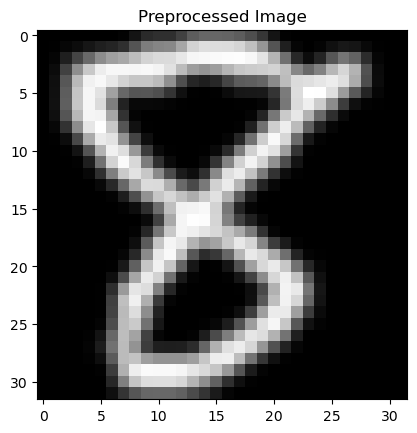

In [17]:
original_mnist_sample = torchvision.io.read_image(os.path.join(TRAIN_DIR , "0098155.png"))
mnist_sample = transform(original_mnist_sample)
print(mnist_sample.shape)
# Show the processed digit
plt.imshow(mnist_sample.permute(1, 2, 0), cmap="gray") # need (C, H, W) -> (H, W, C)
plt.title(f"Preprocessed Image")
plt.show()

### Create dataset

In [18]:
class MNISTDataset(Dataset):
    def __init__(self, dir, transform, type="train"):
        self.transform = transform
        self.dir = dir
        self.fnames = [os.path.join(dir, i) for i in os.listdir(dir) if i.endswith(".png")]
        self.num_samples = len(self.fnames)
        self.type = type
    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        if self.type == "train":
            img_name = fname.split("/")[-1]
            txt_fname = os.path.join(self.dir, (img_name.split(".")[0] + ".txt"))
            # Open the file and read the line
            with open(txt_fname, "r") as file:
                line = file.readline().strip()  # Read the first line and remove whitespace

            # Split the values by tab (\t) or space
            label = list(map(float, line.split()))[0]  # Convert each to
            label = torch.tensor(label, dtype=torch.long)
        
        else:
            label = 0 # not used
        
        # squeeze the shape (1, 64, 64) into (64, 64) to represent 32 sequences
        img  = torch.squeeze(img, 0)
        # reshape img into seq_len = 2, and final shape is (2, 64S*64/2)
        img = img.reshape(SEQ_LEN, -1)
        return img, label

    def __len__(self):
        return self.num_samples

    def get_filename(self, idx):
        if 0 <= idx < self.num_samples:
            return self.fnames[idx]
        else:
            raise IndexError("Index out of range")


#### See 10 transform results compared to original images.
Some images will detect the digit wrongly, but i think they can be ignored.

original img.shape : torch.Size([4, 128, 128])


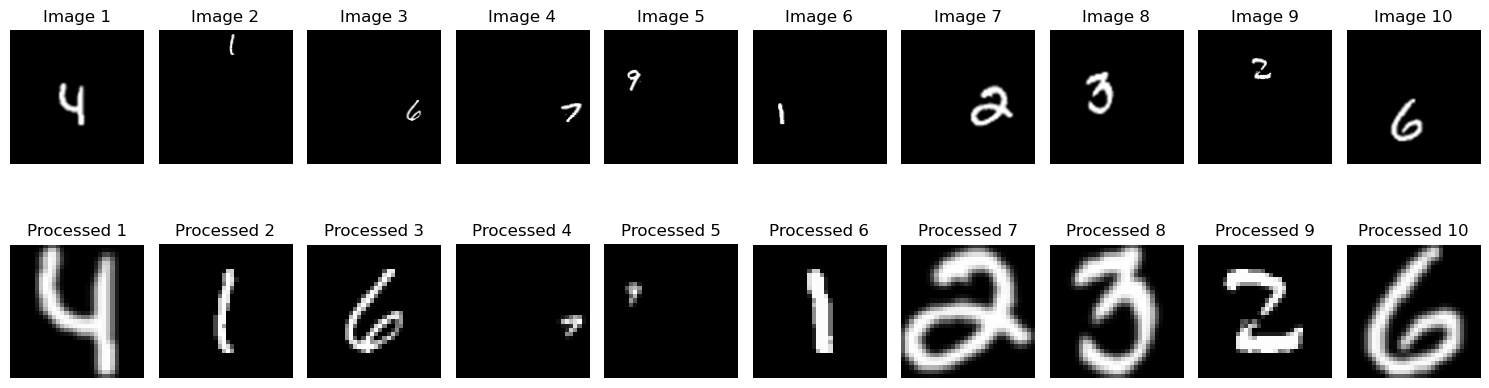

In [19]:
file_paths = [f for f in os.listdir(TRAIN_DIR) if f.endswith(".png")]
np.random.shuffle(file_paths)
# for i in file_paths[:10]:
#     print(i)
img = torchvision.io.read_image(os.path.join(TRAIN_DIR , "0000000.png"))
print("original img.shape :", img.shape)

# Set up a 2-row, 10-column grid
num_images = 10
fig, axes = plt.subplots(2, num_images, figsize=(15, 5))

# turn tensor into PIL image for showing
to_pil = transforms.ToPILImage()

# Loop through the first 10 images and display them
for i in range(num_images):
    img = torchvision.io.read_image(os.path.join(TRAIN_DIR, file_paths[i]))  # Read as Tensor
    pil_img = to_pil(img)  # Convert Tensor to PIL Image
    axes[0][i].imshow(pil_img, cmap="gray")  # Show image
    axes[0][i].axis("off")  # Hide axis
    axes[0][i].set_title(f"Image {i+1}")
    
    # after transform
    mnist_sample = transform(img)
    # Show the processed digit
    axes[1][i].imshow(mnist_sample.permute(1, 2, 0), cmap="gray")
    axes[1][i].axis("off")  # Hide axis
    axes[1][i].set_title(f"Processed {i+1}")
plt.tight_layout()  # Adjust layout
plt.show()  # Show all images in a single figure

### Define Model  
#### nn.RNN explanation:
`output, h_n = torch.nn.RNN(input_size, hidden_size, num_layers=1, nonlinearity='tanh', bias=True, batch_first=False, dropout=0.0, bidirectional=False, device=None, dtype=None)`
* **Batch_first = True**
* If my Input tensor's shape is (32, 32, 32) => (B, seq_len, Hin)
* The dimension of Input feature is 32.
* The length of one sequence of input features is 32, which also means 32 time steps.
* IN output, the shape would be (32, 32, 128)(batch_size, seq_len, hidden_size). Each time step will output a result of hidden layer.
* It returns tuple (output, h_n).
* output is (batch_size, seq_len, H_out), while h_n is (batch_size, Num_layers, H_out).

### A. RNN model

In [20]:
# define RNN model
class RNN_model_MNIST(nn.Module):
    def __init__(self):
        super(RNN_model_MNIST, self).__init__()
        self.rnn_layers = nn.RNN(IMAGE_SIZE*IMAGE_SIZE//SEQ_LEN, 128, num_layers = 1, batch_first = True) # (input size, output size)
        
        self.classifier_layers = nn.Sequential(
                # Flatten layers
                nn.Linear(128, 10),
            )
        
        
    
    def forward(self, x):
        output, _ = self.rnn_layers(x) # output shape is (N, seq_len, Hout)
        # output's shape is (Batch_size, seq_len, Hout)
        
        # Try use all time steps data
        # x = output.reshape(x.size(0), -1)
        
        # Try just see the final time step output
        x = output[:, -1, :]  # get last time step (batch_size, H_out)
        x = self.classifier_layers(x)
        return x

Test On transform action

In [21]:
to_gray = transforms.Grayscale(num_output_channels=1)
img = torchvision.io.read_image(os.path.join(TRAIN_DIR , "0000000.png"))
print("img.shape :", np.array(img).shape)
img = to_pil(img)
print("img.shape :", np.array(img).shape)
img = img.convert("RGB")
print("img.shape :", np.array(img).shape)
img = to_gray(img)
print("img.shape :", np.array(img).shape)

img.shape : (4, 128, 128)
img.shape : (128, 128, 4)
img.shape : (128, 128, 3)
img.shape : (128, 128)


Prepare dataset & dataloader.  
Split the origin train dataset into 70% and 30%.

In [22]:
total_train_dataset = MNISTDataset(TRAIN_DIR, transform, "train")
test_dataset = MNISTDataset(TEST_DIR, transform, "test")

print("length of total_train_datast:", len(total_train_dataset))
print("length of test_datast:", len(test_dataset))
# Define split sizes
train_size = int(0.7 * len(total_train_dataset))  # 70% for training
val_size = len(total_train_dataset) - train_size  # Remaining 30% for validation

# Split dataset
train_dataset, val_dataset = random_split(total_train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False, pin_memory=True)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False, pin_memory=True)
total_train_dataloader = DataLoader(total_train_dataset, batch_size=batch_size_train, shuffle=False, pin_memory=True)

length of total_train_datast: 97396
length of test_datast: 24350


In [23]:
for x, y in train_dataloader:
    print(x[0], y[0])
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor(5)


#### Distribution of train_dataset:  
{0: 7518, 1: 7547, 2: 6715, 3: 6911, 4: 6551, 5: 5991, 6: 6674, 7: 7021, 8: 6620, 9: 6629}

In [24]:
# dict_label = {i : 0 for i in range(10)}
# for _, y in train_dataloader:
#     for label in y:
#         dict_label[int(label)] += 1

# print(dict_label)


Make sure the img shape is correct.  
* (B, H, W)  
For RNN, I input 32 sequences(times steps) into model at a time, and each sequence contain 32 elements.

In [25]:
for i, j in train_dataloader:
    print(i.shape, j.shape)
    break
for i, j in test_dataloader:
    print(i.shape, j.shape)
    break

torch.Size([32, 2, 512]) torch.Size([32])
torch.Size([32, 2, 512]) torch.Size([32])


See some picture and test if dataset work.  
Unsqueeze in order to show the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 32, 32])
torch.Size([3, 138, 138])


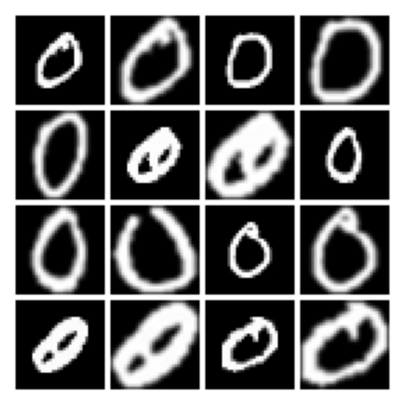

In [26]:
images = [torch.unsqueeze(total_train_dataset[i][0], 0).reshape(1, IMAGE_SIZE, IMAGE_SIZE) for i in range(16)]
print(images[0].shape)
grid_img = torchvision.utils.make_grid(images, nrow=4, padding=2, pad_value=255)
print(grid_img.shape)
plt.figure(figsize=(5,5))
plt.imshow(grid_img.permute(1, 2, 0)) # Convert (C, H, W) -> (H, W, C)
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 32, 32])
torch.Size([3, 138, 138])


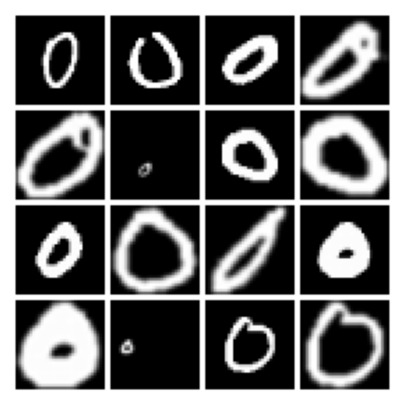

In [27]:
images = [torch.unsqueeze(test_dataset[i][0], 0).reshape(1, IMAGE_SIZE, IMAGE_SIZE) for i in range(16)]
print(images[0].shape)
grid_img = torchvision.utils.make_grid(images, nrow=4, padding=2, pad_value=255)
print(grid_img.shape)
plt.figure(figsize=(5,5))
plt.imshow(grid_img.permute(1, 2, 0)) # Convert (C, H, W) -> (H, W, C)
plt.axis("off")
plt.show()

### Training

In [28]:
model = RNN_model_MNIST().to(device)

# pth_path = 'MNIST_model_RNN.pth'
# state_dict = torch.load(pth_path)
# model.load_state_dict(state_dict)
# print(f"Load pth from {pth_path}")

# set loss function
criterion = nn.CrossEntropyLoss()
# set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999))
# let the LR decay after 10 epochs
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
# Print the model summary
# summary(model, (1, IMAGE_SIZE, IMAGE_SIZE)) # Input size: (Batch_size, height, width), torchinfo.summary need batch size
summary(model, (1, SEQ_LEN, IMAGE_SIZE*IMAGE_SIZE//SEQ_LEN)) # Input size: (Batch_size, height, width), torchinfo.summary need batch size

Layer (type:depth-idx)                   Output Shape              Param #
RNN_model_MNIST                          [1, 10]                   --
├─RNN: 1-1                               [1, 2, 128]               82,176
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 10]                   1,290
Total params: 83,466
Trainable params: 83,466
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.33
Estimated Total Size (MB): 0.34

In [29]:
from tqdm import tqdm
# train and val func for one epoch
def train_epoch(train_dataloader):
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for x, y in tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)
        # clear gradients
        optimizer.zero_grad()
        # predicting
        y_pred = model(x)
        # see loss
        loss = criterion(y_pred, y)
        loss.backward()
        
        # Gradient Clipping
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        # update the parameters
        optimizer.step()

        # Update the LR
        # scheduler.step()

        train_loss += loss.item()
        probs = torch.nn.functional.softmax(y_pred, dim=1)
        train_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return train_acc / len(train_dataloader.dataset), train_loss / len(train_dataloader.dataset)

def val_epoch(val_dataloader):
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(val_dataloader):
            x, y = x.to(device), y.to(device)
            # predicting
            y_pred = model(x)
            # see loss
            loss = criterion(y_pred, y)

            val_loss += loss.item()
            probs = torch.nn.functional.softmax(y_pred, dim=1)
            val_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return val_acc / len(val_dataloader.dataset), val_loss / len(val_dataloader.dataset)

def test(test_dataloader, type="test"):
    pred_labels = []
    total_probs = []
    true_labels = [] # for testing train dataset
    model.eval()
    with torch.no_grad():
        if type == "test":
            for x, _ in tqdm(test_dataloader):
                x = x.to(device)
                # predicting
                y_pred = model(x)
                probs = torch.nn.functional.softmax(y_pred, dim=1)
                pred_labels.extend(torch.argmax(probs, dim=1).cpu().tolist())
            return pred_labels

        else:
            for x, y in tqdm(test_dataloader):
                x = x.to(device)
                # predicting
                y_pred = model(x)
                probs = torch.nn.functional.softmax(y_pred, dim=1)
                total_probs.append(probs)
                pred_labels.extend(torch.argmax(probs, dim=1).cpu().tolist())
                true_labels.extend(y.cpu().tolist())
            return torch.cat(total_probs, dim=0), pred_labels, true_labels

In [30]:
def plt_loss_accuracy_fig(Total_training_loss, Total_validation_loss, Total_training_accuracy, Total_validation_accuracy):
    # visualization the loss and accuracy
    plt.figure()
    plt.plot(range(len(Total_training_loss)), Total_training_loss, 'b-', label='Training_loss')
    plt.plot(range(len(Total_validation_loss)), Total_validation_loss, 'g-', label='validation_loss')
    plt.title('Training & Validation loss')
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(len(Total_training_accuracy)), Total_training_accuracy, 'r-', label='Training_accuracy')
    plt.plot(range(len(Total_validation_accuracy)), Total_validation_accuracy, 'y-', label='Validation_accuracy')
    plt.title('Training & Validation accuracy')
    plt.xlabel('No. of epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [31]:
# Start training and testing
max_accuracy = 0
# For ploting the trend image
total_train_acc = []
total_val_acc = []
total_train_loss = []
total_val_loss = []
for i in range(NUM_EPOCHS):
    train_acc, train_loss = train_epoch(train_dataloader)
    val_acc, val_loss = val_epoch(val_dataloader)
    # record the training data
    total_train_acc.append(train_acc)
    total_val_acc.append(val_acc)

    total_train_loss.append(train_loss)
    total_val_loss.append(val_loss)

    print("Epoch[{:>2d}/{:>2d}] : train_acc = {:.4f}, train_loss = {:.4f}, val_acc = {:.4f}, val_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_acc, train_loss, val_acc, val_loss))
    # update model pth when larger val_acc happens
    if(val_acc > max_accuracy):
        max_accuracy = val_acc
        save_parameters = True
        if save_parameters:
            path = 'MNIST_model_RNN.pth'
            torch.save(model.state_dict(), path)
            print("\t\33[33m====Save model parameters in {:s} when val_acc is {:.4f}====\33[0m".format(path, val_acc))

# save the final epoch's model
path = 'MNIST_model_RNN_final_epoch.pth'
torch.save(model.state_dict(), path)
print("\t\33[33m====Save FINAL model parameters in {:s}====\33[0m".format(path))

100%|██████████| 914/914 [00:26<00:00, 35.11it/s]


Epoch[ 1/20] : train_acc = 0.8595, train_loss = 0.0151, val_acc = 0.8933, val_loss = 0.0119
	====Save model parameters in MNIST_model_RNN.pth when val_acc is 0.8933====


100%|██████████| 914/914 [00:21<00:00, 41.98it/s]


Epoch[ 2/20] : train_acc = 0.8788, train_loss = 0.0130, val_acc = 0.8862, val_loss = 0.0120


100%|██████████| 914/914 [00:15<00:00, 58.00it/s]


Epoch[ 3/20] : train_acc = 0.8841, train_loss = 0.0125, val_acc = 0.8841, val_loss = 0.0130


100%|██████████| 914/914 [00:15<00:00, 59.35it/s]


Epoch[ 4/20] : train_acc = 0.8879, train_loss = 0.0121, val_acc = 0.8825, val_loss = 0.0129


100%|██████████| 914/914 [00:15<00:00, 59.45it/s]


Epoch[ 5/20] : train_acc = 0.8932, train_loss = 0.0117, val_acc = 0.8847, val_loss = 0.0124


100%|██████████| 914/914 [00:21<00:00, 41.59it/s]


Epoch[ 6/20] : train_acc = 0.8953, train_loss = 0.0113, val_acc = 0.8989, val_loss = 0.0114
	====Save model parameters in MNIST_model_RNN.pth when val_acc is 0.8989====


100%|██████████| 914/914 [00:21<00:00, 42.51it/s]


Epoch[ 7/20] : train_acc = 0.8994, train_loss = 0.0111, val_acc = 0.8884, val_loss = 0.0123


100%|██████████| 914/914 [00:21<00:00, 42.76it/s]


Epoch[ 8/20] : train_acc = 0.8975, train_loss = 0.0112, val_acc = 0.8892, val_loss = 0.0125


100%|██████████| 914/914 [00:21<00:00, 42.58it/s]


Epoch[ 9/20] : train_acc = 0.8992, train_loss = 0.0109, val_acc = 0.8949, val_loss = 0.0117


100%|██████████| 914/914 [00:21<00:00, 42.48it/s]


Epoch[10/20] : train_acc = 0.9021, train_loss = 0.0109, val_acc = 0.8994, val_loss = 0.0112
	====Save model parameters in MNIST_model_RNN.pth when val_acc is 0.8994====


100%|██████████| 914/914 [00:20<00:00, 44.23it/s]


Epoch[11/20] : train_acc = 0.9043, train_loss = 0.0104, val_acc = 0.8991, val_loss = 0.0115


100%|██████████| 914/914 [00:21<00:00, 42.51it/s]


Epoch[12/20] : train_acc = 0.9033, train_loss = 0.0104, val_acc = 0.8906, val_loss = 0.0122


100%|██████████| 914/914 [00:21<00:00, 42.17it/s]


Epoch[13/20] : train_acc = 0.9040, train_loss = 0.0104, val_acc = 0.9041, val_loss = 0.0105
	====Save model parameters in MNIST_model_RNN.pth when val_acc is 0.9041====


100%|██████████| 914/914 [00:22<00:00, 41.09it/s]


Epoch[14/20] : train_acc = 0.9076, train_loss = 0.0102, val_acc = 0.8954, val_loss = 0.0114


100%|██████████| 914/914 [00:21<00:00, 43.10it/s]


Epoch[15/20] : train_acc = 0.9042, train_loss = 0.0104, val_acc = 0.8982, val_loss = 0.0113


100%|██████████| 914/914 [00:21<00:00, 41.58it/s]


Epoch[16/20] : train_acc = 0.9061, train_loss = 0.0102, val_acc = 0.9030, val_loss = 0.0109


100%|██████████| 914/914 [00:19<00:00, 47.59it/s]


Epoch[17/20] : train_acc = 0.9070, train_loss = 0.0102, val_acc = 0.9025, val_loss = 0.0112


100%|██████████| 914/914 [00:21<00:00, 42.66it/s]


Epoch[18/20] : train_acc = 0.9067, train_loss = 0.0102, val_acc = 0.9000, val_loss = 0.0109


100%|██████████| 914/914 [00:22<00:00, 41.11it/s]


Epoch[19/20] : train_acc = 0.9089, train_loss = 0.0099, val_acc = 0.9016, val_loss = 0.0110


100%|██████████| 914/914 [00:21<00:00, 41.58it/s]


Epoch[20/20] : train_acc = 0.9090, train_loss = 0.0099, val_acc = 0.8958, val_loss = 0.0118
	====Save FINAL model parameters in MNIST_model_RNN_final_epoch.pth====


### Plot trend of acc and loss during process of training.

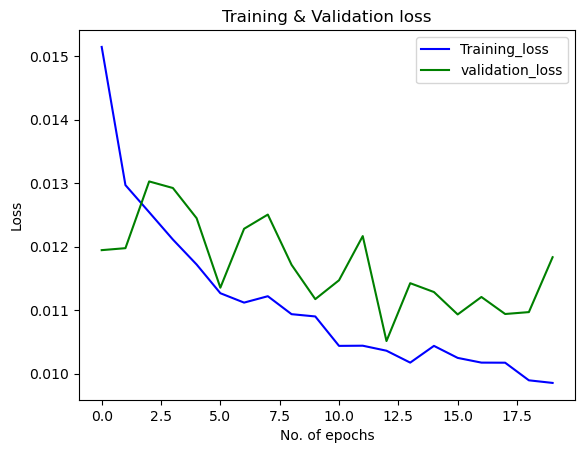

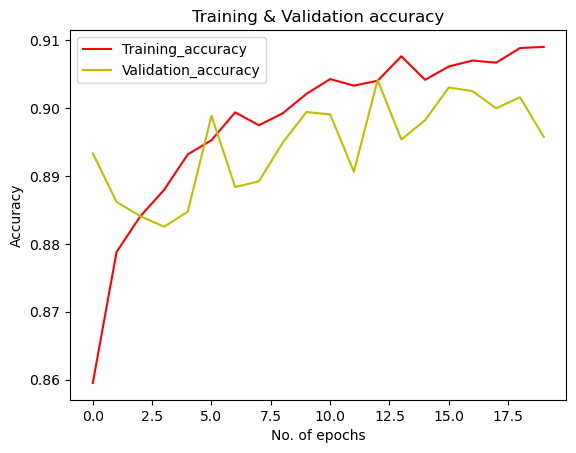

In [32]:
plt_loss_accuracy_fig(total_train_loss, total_val_loss, total_train_acc, total_val_acc)

In [33]:
def plot_confusion_matrix(pred_labels, true_labels, num_classes=10):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))

    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(7, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))

    # Add labels and title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

### Finally test on total train dataset.  
1. Get:
* confusion matrix
* top-1 acc
* top-3 acc

In [34]:
# Reload the best model
model = RNN_model_MNIST().to(device)

pth_path = 'MNIST_model_RNN.pth'
state_dict = torch.load(pth_path)
model.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")


Load pth from MNIST_model_RNN.pth


100%|██████████| 3044/3044 [01:13<00:00, 41.56it/s]


Top-1 Accuracy: 0.9110
Top-3 Accuracy: 0.9765


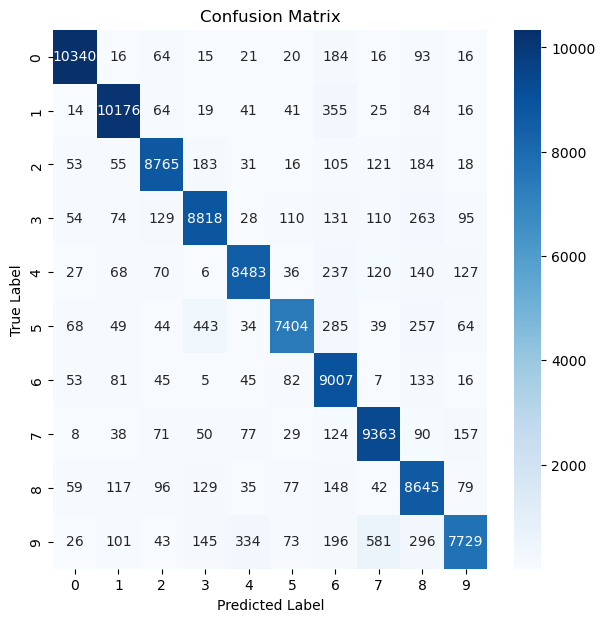

In [35]:
total_train_probs, train_pred_labels, true_labels = test(total_train_dataloader, type="train")

top_1_acc = 0.0
top_3_acc = 0.0
num_samples = len(true_labels)

for probs, label in zip(total_train_probs, true_labels):
    # Get top 3 predictions
    top3_probs, top3_indices = torch.topk(probs, 3, dim=0, largest=True, sorted=True)

    # Top-1 accuracy: if the top-1 predicted class matches the true label
    if top3_indices[0] == label:
        top_1_acc += 1

    # Top-3 accuracy: if the true label is among the top 3 predicted classes
    if label in top3_indices:
        top_3_acc += 1

# Calculate the final accuracy
top_1_acc /= num_samples
top_3_acc /= num_samples

print(f"Top-1 Accuracy: {top_1_acc:.4f}")
print(f"Top-3 Accuracy: {top_3_acc:.4f}")

plot_confusion_matrix(train_pred_labels, true_labels)

2. List **number of layers and parameters** used in your architecture.  
* Calculate the value of $$\frac{top-1\ accuracy}{\# of parameters}$$

In [36]:
def get_num_layers_and_params(model):
    num_layers = 0
    num_params = 0

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.BatchNorm2d, nn.Linear, nn.ReLU, nn.MaxPool2d)):
            num_layers += 1  # Count only meaningful layers

        # Sum up the parameters only from leaf modules (actual layers, not containers)
        if len(list(module.children())) == 0:  # Ensures we are not counting Sequential itself
            num_params += sum(p.numel() for p in module.parameters() if p.requires_grad)

    return num_layers, num_params

# Get number of layers and parameters
num_layers, num_params = get_num_layers_and_params(model)
print(f"Number of layers: {num_layers}")
print(f"Number of parameters: {num_params}")
print(f"Top-1 Accuracy: {top_1_acc:.4f}")
print(f"Top-1 Accuracy(%): {top_1_acc*100:.4f}")
print(f"top-1 accuracy / # of parameters: {top_1_acc / num_params:.10f}")
print(f"top-1 accuracy(%) / # of parameters: {top_1_acc*100 / num_params:.10f}")



Number of layers: 1
Number of parameters: 83466
Top-1 Accuracy: 0.9110
Top-1 Accuracy(%): 91.1023
top-1 accuracy / # of parameters: 0.0000109149
top-1 accuracy(%) / # of parameters: 0.0010914900


### Test on test dataset
3. Output the prediction result

In [37]:
import pandas as pd

# result dict storing the testing result
dict_test = {
    "image": [],
    "class": []
}

pred_labels = test(test_dataloader, type="test")
if len(pred_labels) !=  len(test_dataset):
    print(len(pred_labels), len(test_dataset))
    print("\33[35mError: Not available results.\33[0m")
# prepare for getting dataframe
for i in range(len(test_dataset)):
    dict_test["image"].append(test_dataset.get_filename(i).split("/")[-1]) # access the filename
    dict_test["class"].append(pred_labels[i])

csv_path = 'HW3_prob1_RNN.csv'
df = pd.DataFrame(dict_test)
df.to_csv(csv_path,index=False)
print("Successfully write into {:s} file.".format(csv_path))

100%|██████████| 761/761 [00:19<00:00, 39.36it/s]

Successfully write into HW3_prob1_RNN.csv file.


### B. LSTM Model

In [38]:
# define LSTM model
class LSTM_model_MNIST(nn.Module):
    def __init__(self):
        super(LSTM_model_MNIST, self).__init__()
        self.lstm_layers = nn.LSTM(IMAGE_SIZE*IMAGE_SIZE//SEQ_LEN, 32, num_layers = 1, batch_first = True) # (input size, output size)
        
        self.classifier_layers = nn.Sequential(
                # Flatten layers
                nn.Linear(32, 10)
            )


    def forward(self, x):
        output, (hn, cn) = self.lstm_layers(x) # output shape is (N,L,D∗Hout) 

        # Try use all time steps data
        # x = output.reshape(x.size(0), -1)
        
        # Try just see the final time step output
        x = output[:, -1, :]  # get last time step (batch_size, H_out)
        # print("CCC", x.shape) 
        x = self.classifier_layers(x)
        return x

In [39]:
model = LSTM_model_MNIST().to(device)

# pth_path = 'MNIST_model_LSTM.pth'
# state_dict = torch.load(pth_path)
# model.load_state_dict(state_dict)
# print(f"Load pth from {pth_path}")

# set loss function
criterion = nn.CrossEntropyLoss()
# set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# let the LR decay after 10 epochs
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
# Print the model summary
summary(model, (1, SEQ_LEN, IMAGE_SIZE*IMAGE_SIZE//SEQ_LEN)) # Input size: (height, width)

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_model_MNIST                         [1, 10]                   --
├─LSTM: 1-1                              [1, 2, 32]                69,888
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 10]                   330
Total params: 70,218
Trainable params: 70,218
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.14
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.28
Estimated Total Size (MB): 0.29

In [40]:
# Start training and testing
max_accuracy = 0
# For ploting the trend image
total_train_acc = []
total_val_acc = []
total_train_loss = []
total_val_loss = []
for i in range(NUM_EPOCHS):
    train_acc, train_loss = train_epoch(train_dataloader)
    val_acc, val_loss = val_epoch(val_dataloader)
    # record the training data
    total_train_acc.append(train_acc)
    total_val_acc.append(val_acc)

    total_train_loss.append(train_loss)
    total_val_loss.append(val_loss)

    print("Epoch[{:>2d}/{:>2d}] : train_acc = {:.4f}, train_loss = {:.4f}, val_acc = {:.4f}, val_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_acc, train_loss, val_acc, val_loss))
    # update model pth when larger val_acc happens
    if(val_acc > max_accuracy):
        max_accuracy = val_acc
        save_parameters = True
        if save_parameters:
            path = 'MNIST_model_LSTM.pth'
            torch.save(model.state_dict(), path)
            print("\t\33[33m====Save model parameters in {:s} when val_acc is {:.4f}====\33[0m".format(path, val_acc))

# save the final epoch's model
path = 'MNIST_model_LSTM_final_epoch.pth'
torch.save(model.state_dict(), path)
print("\t\33[33m====Save FINAL model parameters in {:s}====\33[0m".format(path))

100%|██████████| 914/914 [00:21<00:00, 41.65it/s]


Epoch[ 1/20] : train_acc = 0.8812, train_loss = 0.0122, val_acc = 0.8958, val_loss = 0.0104
	====Save model parameters in MNIST_model_LSTM.pth when val_acc is 0.8958====


100%|██████████| 914/914 [00:21<00:00, 41.91it/s]


Epoch[ 2/20] : train_acc = 0.9139, train_loss = 0.0087, val_acc = 0.9179, val_loss = 0.0085
	====Save model parameters in MNIST_model_LSTM.pth when val_acc is 0.9179====


100%|██████████| 914/914 [00:22<00:00, 41.38it/s]


Epoch[ 3/20] : train_acc = 0.9212, train_loss = 0.0080, val_acc = 0.9115, val_loss = 0.0089


100%|██████████| 914/914 [00:21<00:00, 43.11it/s]


Epoch[ 4/20] : train_acc = 0.9247, train_loss = 0.0076, val_acc = 0.9168, val_loss = 0.0086


100%|██████████| 914/914 [00:22<00:00, 41.53it/s]


Epoch[ 5/20] : train_acc = 0.9256, train_loss = 0.0074, val_acc = 0.9229, val_loss = 0.0080
	====Save model parameters in MNIST_model_LSTM.pth when val_acc is 0.9229====


100%|██████████| 914/914 [00:17<00:00, 51.02it/s]


Epoch[ 6/20] : train_acc = 0.9297, train_loss = 0.0070, val_acc = 0.9230, val_loss = 0.0081
	====Save model parameters in MNIST_model_LSTM.pth when val_acc is 0.9230====


100%|██████████| 914/914 [00:21<00:00, 43.01it/s]


Epoch[ 7/20] : train_acc = 0.9318, train_loss = 0.0067, val_acc = 0.9199, val_loss = 0.0083


100%|██████████| 914/914 [00:21<00:00, 41.70it/s]


Epoch[ 8/20] : train_acc = 0.9345, train_loss = 0.0065, val_acc = 0.9183, val_loss = 0.0085


100%|██████████| 914/914 [00:22<00:00, 40.38it/s]


Epoch[ 9/20] : train_acc = 0.9373, train_loss = 0.0063, val_acc = 0.9246, val_loss = 0.0081
	====Save model parameters in MNIST_model_LSTM.pth when val_acc is 0.9246====


100%|██████████| 914/914 [00:21<00:00, 42.92it/s]


Epoch[10/20] : train_acc = 0.9369, train_loss = 0.0062, val_acc = 0.9210, val_loss = 0.0083


100%|██████████| 914/914 [00:15<00:00, 57.66it/s]


Epoch[11/20] : train_acc = 0.9395, train_loss = 0.0060, val_acc = 0.9250, val_loss = 0.0080
	====Save model parameters in MNIST_model_LSTM.pth when val_acc is 0.9250====


100%|██████████| 914/914 [00:15<00:00, 58.05it/s]


Epoch[12/20] : train_acc = 0.9408, train_loss = 0.0058, val_acc = 0.9277, val_loss = 0.0077
	====Save model parameters in MNIST_model_LSTM.pth when val_acc is 0.9277====


100%|██████████| 914/914 [00:15<00:00, 57.90it/s]


Epoch[13/20] : train_acc = 0.9419, train_loss = 0.0057, val_acc = 0.9252, val_loss = 0.0078


100%|██████████| 914/914 [00:15<00:00, 57.96it/s]


Epoch[14/20] : train_acc = 0.9447, train_loss = 0.0055, val_acc = 0.9292, val_loss = 0.0077
	====Save model parameters in MNIST_model_LSTM.pth when val_acc is 0.9292====


100%|██████████| 914/914 [00:15<00:00, 57.15it/s]


Epoch[15/20] : train_acc = 0.9462, train_loss = 0.0054, val_acc = 0.9272, val_loss = 0.0079


100%|██████████| 914/914 [00:15<00:00, 58.00it/s]


Epoch[16/20] : train_acc = 0.9455, train_loss = 0.0054, val_acc = 0.9292, val_loss = 0.0078
	====Save model parameters in MNIST_model_LSTM.pth when val_acc is 0.9292====


100%|██████████| 914/914 [00:15<00:00, 57.14it/s]


Epoch[17/20] : train_acc = 0.9458, train_loss = 0.0054, val_acc = 0.9306, val_loss = 0.0074
	====Save model parameters in MNIST_model_LSTM.pth when val_acc is 0.9306====


100%|██████████| 914/914 [00:15<00:00, 57.50it/s]


Epoch[18/20] : train_acc = 0.9482, train_loss = 0.0052, val_acc = 0.9255, val_loss = 0.0080


100%|██████████| 914/914 [00:15<00:00, 57.89it/s]


Epoch[19/20] : train_acc = 0.9462, train_loss = 0.0054, val_acc = 0.9282, val_loss = 0.0077


100%|██████████| 914/914 [00:15<00:00, 58.06it/s]

Epoch[20/20] : train_acc = 0.9463, train_loss = 0.0053, val_acc = 0.9270, val_loss = 0.0079
	====Save FINAL model parameters in MNIST_model_LSTM_final_epoch.pth====


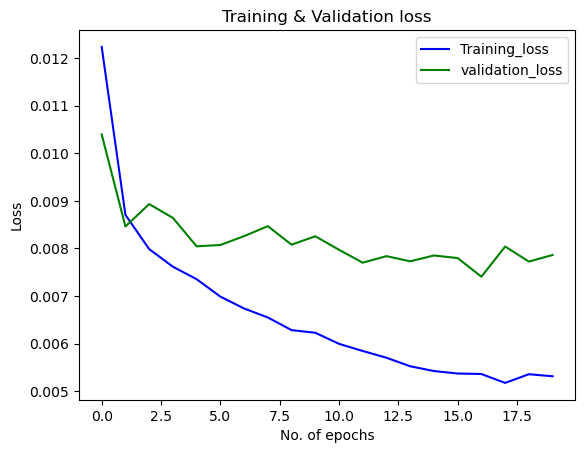

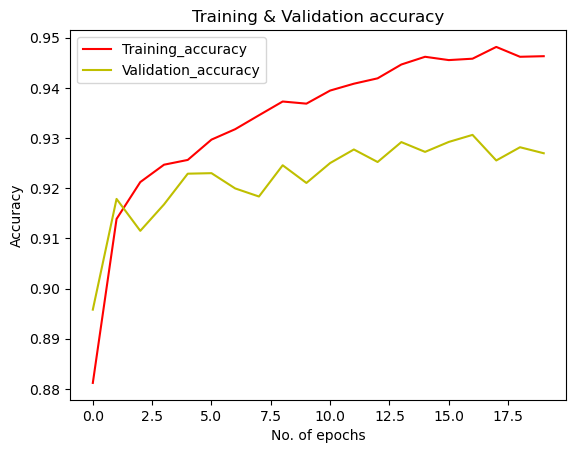

In [41]:
plt_loss_accuracy_fig(total_train_loss, total_val_loss, total_train_acc, total_val_acc)

### Finally test on total train dataset.  
1. Get:
* confusion matrix
* top-1 acc
* top-3 acc

In [42]:
# Reload the best model
model = LSTM_model_MNIST().to(device)

pth_path = 'MNIST_model_LSTM.pth'
state_dict = torch.load(pth_path)
model.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")


Load pth from MNIST_model_LSTM.pth


100%|██████████| 3044/3044 [00:51<00:00, 58.66it/s]


Top-1 Accuracy: 0.9465
Top-3 Accuracy: 0.9870


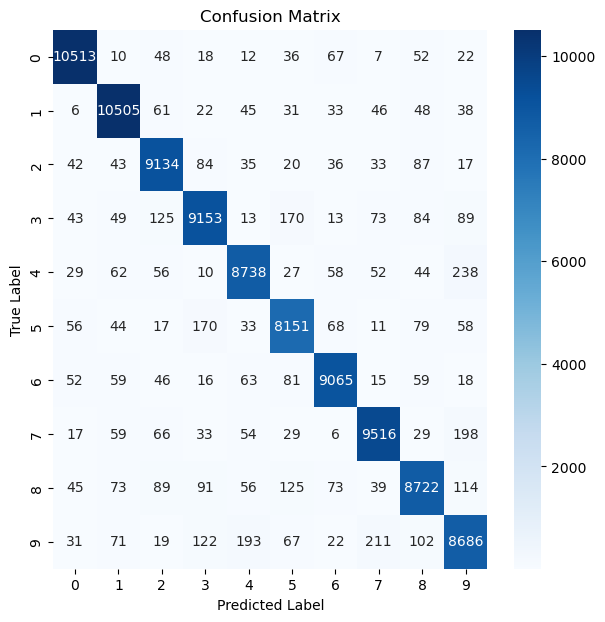

In [43]:
total_train_probs, train_pred_labels, true_labels = test(total_train_dataloader, type="train")

top_1_acc = 0.0
top_3_acc = 0.0
num_samples = len(true_labels)

for probs, label in zip(total_train_probs, true_labels):
    # Get top 3 predictions
    top3_probs, top3_indices = torch.topk(probs, 3, dim=0, largest=True, sorted=True)

    # Top-1 accuracy: if the top-1 predicted class matches the true label
    if top3_indices[0] == label:
        top_1_acc += 1

    # Top-3 accuracy: if the true label is among the top 3 predicted classes
    if label in top3_indices:
        top_3_acc += 1

# Calculate the final accuracy
top_1_acc /= num_samples
top_3_acc /= num_samples

print(f"Top-1 Accuracy: {top_1_acc:.4f}")
print(f"Top-3 Accuracy: {top_3_acc:.4f}")

plot_confusion_matrix(train_pred_labels, true_labels)

2. List **number of layers and parameters** used in your architecture.  
* Calculate the value of $$\frac{top-1\ accuracy}{\# of parameters}$$

In [44]:
def get_num_layers_and_params(model):
    num_layers = 0
    num_params = 0

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.BatchNorm2d, nn.Linear, nn.ReLU, nn.MaxPool2d)):
            num_layers += 1  # Count only meaningful layers

        # Sum up the parameters only from leaf modules (actual layers, not containers)
        if len(list(module.children())) == 0:  # Ensures we are not counting Sequential itself
            num_params += sum(p.numel() for p in module.parameters() if p.requires_grad)

    return num_layers, num_params

# Get number of layers and parameters
num_layers, num_params = get_num_layers_and_params(model)
print(f"Number of layers: {num_layers}")
print(f"Number of parameters: {num_params}")
print(f"Top-1 Accuracy: {top_1_acc:.4f}")
print(f"Top-1 Accuracy(%): {top_1_acc*100:.4f}")
print(f"top-1 accuracy / # of parameters: {top_1_acc / num_params:.10f}")
print(f"top-1 accuracy(%) / # of parameters: {top_1_acc*100 / num_params:.10f}")



Number of layers: 1
Number of parameters: 70218
Top-1 Accuracy: 0.9465
Top-1 Accuracy(%): 94.6476
top-1 accuracy / # of parameters: 0.0000134791
top-1 accuracy(%) / # of parameters: 0.0013479111


### Test on test dataset
3. Output the prediction result

In [45]:
import pandas as pd

# result dict storing the testing result
dict_test = {
    "image": [],
    "class": []
}

pred_labels = test(test_dataloader, type="test")
if len(pred_labels) !=  len(test_dataset):
    print(len(pred_labels), len(test_dataset))
    print("\33[35mError: Not available results.\33[0m")
# prepare for getting dataframe
for i in range(len(test_dataset)):
    dict_test["image"].append(test_dataset.get_filename(i).split("/")[-1]) # access the filename
    dict_test["class"].append(pred_labels[i])

csv_path = 'HW3_prob1_LSTM.csv'
df = pd.DataFrame(dict_test)
df.to_csv(csv_path,index=False)
print("Successfully write into {:s} file.".format(csv_path))

100%|██████████| 761/761 [00:10<00:00, 72.28it/s]


Successfully write into HW3_prob1_LSTM.csv file.


### C. GRU Model

In [46]:
# define GRU model
class GRU_model_MNIST(nn.Module):
    def __init__(self):
        super(GRU_model_MNIST, self).__init__()
        self.lstm_layers = nn.GRU(IMAGE_SIZE*IMAGE_SIZE//SEQ_LEN, 32, num_layers = 1, batch_first = True) # (input size, output size)
        
        self.classifier_layers = nn.Sequential(
                # Flatten layers
                nn.Linear(32, 10)
            )


    def forward(self, x):
        output, hn = self.lstm_layers(x) # output shape is (N,L,D∗Hout) 

        # Try use all time steps data
        # x = output.reshape(x.size(0), -1)

        # Try just see the final time step output
        x = output[:, -1, :]  # get last time step (batch_size, H_out)
        # print("CCC", x.shape) 
        x = self.classifier_layers(x)
        return x

In [47]:
model = GRU_model_MNIST().to(device)

# pth_path = 'MNIST_model_GRU.pth'
# state_dict = torch.load(pth_path)
# model.load_state_dict(state_dict)
# print(f"Load pth from {pth_path}")

# set loss function
criterion = nn.CrossEntropyLoss()
# set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# let the LR decay after 10 epochs
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
# Print the model summary
summary(model, (1, SEQ_LEN, IMAGE_SIZE*IMAGE_SIZE//SEQ_LEN)) # Input size: (height, width)

Layer (type:depth-idx)                   Output Shape              Param #
GRU_model_MNIST                          [1, 10]                   --
├─GRU: 1-1                               [1, 2, 32]                52,416
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 10]                   330
Total params: 52,746
Trainable params: 52,746
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.22

In [48]:
# Start training and testing
max_accuracy = 0
# For ploting the trend image
total_train_acc = []
total_val_acc = []
total_train_loss = []
total_val_loss = []
for i in range(NUM_EPOCHS):
    train_acc, train_loss = train_epoch(train_dataloader)
    val_acc, val_loss = val_epoch(val_dataloader)
    # record the training data
    total_train_acc.append(train_acc)
    total_val_acc.append(val_acc)

    total_train_loss.append(train_loss)
    total_val_loss.append(val_loss)

    print("Epoch[{:>2d}/{:>2d}] : train_acc = {:.4f}, train_loss = {:.4f}, val_acc = {:.4f}, val_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_acc, train_loss, val_acc, val_loss))
    # update model pth when larger val_acc happens
    if(val_acc > max_accuracy):
        max_accuracy = val_acc
        save_parameters = True
        if save_parameters:
            path = 'MNIST_model_GRU.pth'
            torch.save(model.state_dict(), path)
            print("\t\33[33m====Save model parameters in {:s} when val_acc is {:.4f}====\33[0m".format(path, val_acc))

# save the final epoch's model
path = 'MNIST_model_GRU_final_epoch.pth'
torch.save(model.state_dict(), path)
print("\t\33[33m====Save FINAL model parameters in {:s}====\33[0m".format(path))

100%|██████████| 914/914 [00:15<00:00, 57.86it/s]


Epoch[ 1/20] : train_acc = 0.8772, train_loss = 0.0127, val_acc = 0.9008, val_loss = 0.0104
	====Save model parameters in MNIST_model_GRU.pth when val_acc is 0.9008====


100%|██████████| 914/914 [00:16<00:00, 57.05it/s]


Epoch[ 2/20] : train_acc = 0.9064, train_loss = 0.0097, val_acc = 0.9058, val_loss = 0.0096
	====Save model parameters in MNIST_model_GRU.pth when val_acc is 0.9058====


100%|██████████| 914/914 [00:15<00:00, 57.48it/s]


Epoch[ 3/20] : train_acc = 0.9129, train_loss = 0.0090, val_acc = 0.9126, val_loss = 0.0093
	====Save model parameters in MNIST_model_GRU.pth when val_acc is 0.9126====


100%|██████████| 914/914 [00:15<00:00, 57.57it/s]


Epoch[ 4/20] : train_acc = 0.9166, train_loss = 0.0085, val_acc = 0.9060, val_loss = 0.0095


100%|██████████| 914/914 [00:15<00:00, 57.58it/s]


Epoch[ 5/20] : train_acc = 0.9180, train_loss = 0.0082, val_acc = 0.9136, val_loss = 0.0091
	====Save model parameters in MNIST_model_GRU.pth when val_acc is 0.9136====


100%|██████████| 914/914 [00:16<00:00, 57.04it/s]


Epoch[ 6/20] : train_acc = 0.9226, train_loss = 0.0080, val_acc = 0.9143, val_loss = 0.0090
	====Save model parameters in MNIST_model_GRU.pth when val_acc is 0.9143====


100%|██████████| 914/914 [00:15<00:00, 57.41it/s]


Epoch[ 7/20] : train_acc = 0.9208, train_loss = 0.0081, val_acc = 0.9129, val_loss = 0.0092


100%|██████████| 914/914 [00:15<00:00, 57.37it/s]


Epoch[ 8/20] : train_acc = 0.9240, train_loss = 0.0077, val_acc = 0.9139, val_loss = 0.0090


100%|██████████| 914/914 [00:15<00:00, 57.31it/s]


Epoch[ 9/20] : train_acc = 0.9267, train_loss = 0.0075, val_acc = 0.9185, val_loss = 0.0087
	====Save model parameters in MNIST_model_GRU.pth when val_acc is 0.9185====


100%|██████████| 914/914 [00:16<00:00, 56.98it/s]


Epoch[10/20] : train_acc = 0.9280, train_loss = 0.0074, val_acc = 0.9162, val_loss = 0.0090


100%|██████████| 914/914 [00:15<00:00, 57.81it/s]


Epoch[11/20] : train_acc = 0.9262, train_loss = 0.0075, val_acc = 0.9175, val_loss = 0.0087


100%|██████████| 914/914 [00:15<00:00, 57.43it/s]


Epoch[12/20] : train_acc = 0.9284, train_loss = 0.0072, val_acc = 0.9155, val_loss = 0.0089


100%|██████████| 914/914 [00:16<00:00, 54.35it/s]


Epoch[13/20] : train_acc = 0.9288, train_loss = 0.0071, val_acc = 0.9192, val_loss = 0.0087
	====Save model parameters in MNIST_model_GRU.pth when val_acc is 0.9192====


100%|██████████| 914/914 [00:15<00:00, 57.57it/s]


Epoch[14/20] : train_acc = 0.9302, train_loss = 0.0071, val_acc = 0.9167, val_loss = 0.0089


100%|██████████| 914/914 [00:15<00:00, 57.32it/s]


Epoch[15/20] : train_acc = 0.9311, train_loss = 0.0069, val_acc = 0.9147, val_loss = 0.0090


100%|██████████| 914/914 [00:15<00:00, 57.88it/s]


Epoch[16/20] : train_acc = 0.9320, train_loss = 0.0068, val_acc = 0.9232, val_loss = 0.0083
	====Save model parameters in MNIST_model_GRU.pth when val_acc is 0.9232====


100%|██████████| 914/914 [00:15<00:00, 57.34it/s]


Epoch[17/20] : train_acc = 0.9341, train_loss = 0.0067, val_acc = 0.9216, val_loss = 0.0086


100%|██████████| 914/914 [00:15<00:00, 57.73it/s]


Epoch[18/20] : train_acc = 0.9353, train_loss = 0.0066, val_acc = 0.9234, val_loss = 0.0083
	====Save model parameters in MNIST_model_GRU.pth when val_acc is 0.9234====


100%|██████████| 914/914 [00:15<00:00, 57.16it/s]


Epoch[19/20] : train_acc = 0.9347, train_loss = 0.0065, val_acc = 0.9203, val_loss = 0.0087


100%|██████████| 914/914 [00:15<00:00, 58.21it/s]

Epoch[20/20] : train_acc = 0.9345, train_loss = 0.0066, val_acc = 0.9202, val_loss = 0.0086
	====Save FINAL model parameters in MNIST_model_GRU_final_epoch.pth====


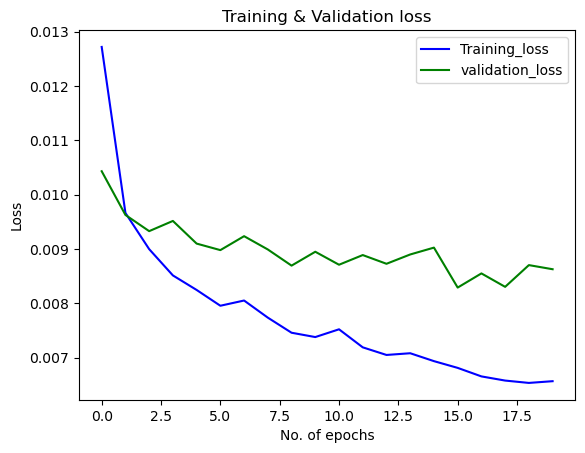

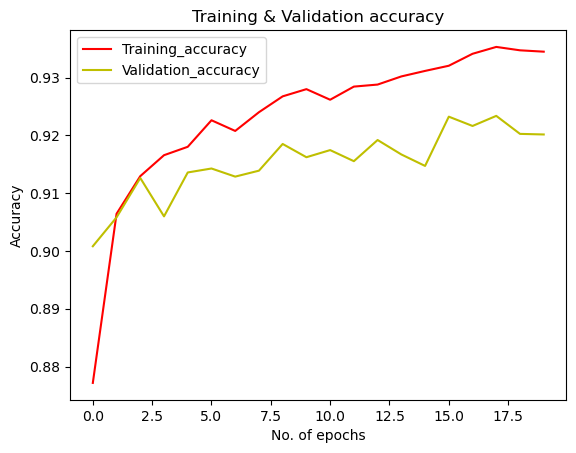

In [49]:
plt_loss_accuracy_fig(total_train_loss, total_val_loss, total_train_acc, total_val_acc)

### Finally test on total train dataset.  
1. Get:
* confusion matrix
* top-1 acc
* top-3 acc

In [50]:
# Reload the best model
model = GRU_model_MNIST().to(device)

pth_path = 'MNIST_model_GRU.pth'
state_dict = torch.load(pth_path)
model.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")


Load pth from MNIST_model_GRU.pth


100%|██████████| 3044/3044 [00:51<00:00, 58.65it/s]


Top-1 Accuracy: 0.9343
Top-3 Accuracy: 0.9838


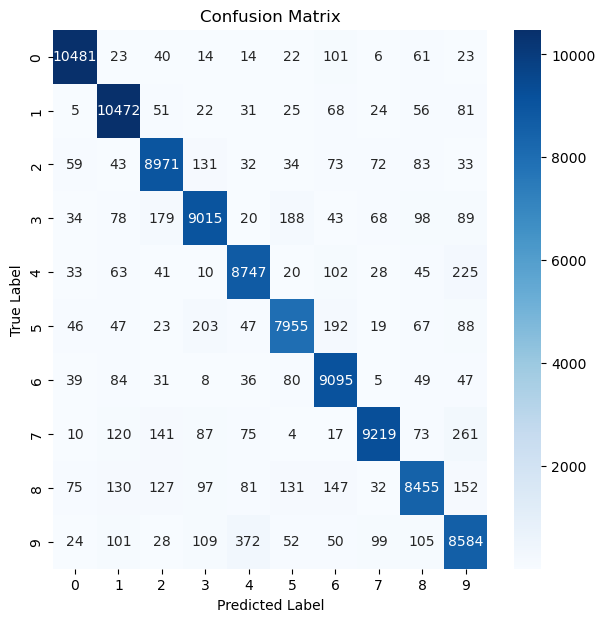

In [51]:
total_train_probs, train_pred_labels, true_labels = test(total_train_dataloader, type="train")

top_1_acc = 0.0
top_3_acc = 0.0
num_samples = len(true_labels)

for probs, label in zip(total_train_probs, true_labels):
    # Get top 3 predictions
    top3_probs, top3_indices = torch.topk(probs, 3, dim=0, largest=True, sorted=True)

    # Top-1 accuracy: if the top-1 predicted class matches the true label
    if top3_indices[0] == label:
        top_1_acc += 1

    # Top-3 accuracy: if the true label is among the top 3 predicted classes
    if label in top3_indices:
        top_3_acc += 1

# Calculate the final accuracy
top_1_acc /= num_samples
top_3_acc /= num_samples

print(f"Top-1 Accuracy: {top_1_acc:.4f}")
print(f"Top-3 Accuracy: {top_3_acc:.4f}")

plot_confusion_matrix(train_pred_labels, true_labels)

2. List **number of layers and parameters** used in your architecture.  
* Calculate the value of $$\frac{top-1\ accuracy}{\# of parameters}$$

In [52]:
def get_num_layers_and_params(model):
    num_layers = 0
    num_params = 0

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.BatchNorm2d, nn.Linear, nn.ReLU, nn.MaxPool2d)):
            num_layers += 1  # Count only meaningful layers

        # Sum up the parameters only from leaf modules (actual layers, not containers)
        if len(list(module.children())) == 0:  # Ensures we are not counting Sequential itself
            num_params += sum(p.numel() for p in module.parameters() if p.requires_grad)

    return num_layers, num_params

# Get number of layers and parameters
num_layers, num_params = get_num_layers_and_params(model)
print(f"Number of layers: {num_layers}")
print(f"Number of parameters: {num_params}")
print(f"Top-1 Accuracy: {top_1_acc:.4f}")
print(f"Top-1 Accuracy(%): {top_1_acc*100:.4f}")
print(f"top-1 accuracy / # of parameters: {top_1_acc / num_params:.10f}")
print(f"top-1 accuracy(%) / # of parameters: {top_1_acc*100 / num_params:.10f}")



Number of layers: 1
Number of parameters: 52746
Top-1 Accuracy: 0.9343
Top-1 Accuracy(%): 93.4268
top-1 accuracy / # of parameters: 0.0000177126
top-1 accuracy(%) / # of parameters: 0.0017712591


### Test on test dataset
3. Output the prediction result

In [53]:
import pandas as pd

# result dict storing the testing result
dict_test = {
    "image": [],
    "class": []
}

pred_labels = test(test_dataloader, type="test")
if len(pred_labels) !=  len(test_dataset):
    print(len(pred_labels), len(test_dataset))
    print("\33[35mError: Not available results.\33[0m")
# prepare for getting dataframe
for i in range(len(test_dataset)):
    dict_test["image"].append(test_dataset.get_filename(i).split("/")[-1]) # access the filename
    dict_test["class"].append(pred_labels[i])

csv_path = 'HW3_prob1_GRU.csv'
df = pd.DataFrame(dict_test)
df.to_csv(csv_path,index=False)
print("Successfully write into {:s} file.".format(csv_path))

100%|██████████| 761/761 [00:10<00:00, 72.51it/s]

Successfully write into HW3_prob1_GRU.csv file.


## Conclusion 
#### Compare different model results from SimpleRNN, LSTM, GRU.
1. **SimpleRNN**  
Number of parameters: 83466
* Top-1 Accuracy: 0.9110
* Top-3 Accuracy: 0.9765
2. **LSTM**  
Number of parameters: 70218
* Top-1 Accuracy: 0.9465
* Top-3 Accuracy: 0.9870

3. **GRU**  
Number of parameters: 52746
* Top-1 Accuracy: 0.9343
* Top-3 Accuracy: 0.9838
